# Project Milestone 3
## Project title: "Firearms debate in the USA and its relation to mass shootings"

Students: Thomas **Defauw**, Margaux **L'Eplattenier**, Clément **Rio**, Zewei **Xu**<br>
Due date: December 17, 2021

In [1]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tld import get_tld
import json
import bz2
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Disable some pandas warnings we don't want in the notebook
pd.options.mode.chained_assignment = None

## 0 - Accessing the data from Quotebank and the speaker attributes dataset

The Quotebank dataset is very large in size and it is not feasible to treat it using only RAM memory. In order to circumvent this problem, we chose to **filter out all the quotes that were not linked to our study**. 

For this second milestone, we chose a simple algorithm that consisted in selecting only the quotes that contained at least one of the following keywords: 'gun', 'shooting', 'firearm'. The selected quotes were written to a new file: 'quotes-cropped.json', which was much more reasonnable in size: around 550 Mo. This was done on a **Google Colab** so that we could access the Quotebank dataset from Drive.

We know this is not a perfect filter, but it should get the job done for these initial findings. For milestone 3, we plan on using a **supervised learning** algorithm in order to identify quotes that speak of shootings/guns with higher precision.

The following code is used to create a **new file with the quotes and the country where they come from**. This way, we select only the quotes that come from the American news. We have commented the code so that is does not need to run again (it can take some time as you can imagine!), but it is here so you can see how we obtained our data set. 

NB: Even though it is drasticly smaller in size then the raw data, our data file is nevertheless too heavy to be uploaded on GitHub (550 Mo). Please let us know if you wish to have the file and we will happily send it to you.

In [2]:
#def get_domain(url):
#    res = get_tld(url, as_object=True)
#    return res.domain
#
#new_src = pd.read_csv('data/news.txt', delimiter="\t", header=None, encoding = "ISO-8859-1")
#new_src.columns=['id','unknown','date','country','media','website','title']
#new_src['domain']=new_src.apply(lambda x : get_domain(x['website']),axis=1)
#new_src.drop_duplicates(inplace=True, subset=['domain'], keep='first')

#path_to_out = 'data/quotes-cropped-with-country.json.bz2'
#with bz2.open("data/quotes-cropped.json.bz2", 'rb') as s_file:
#    with bz2.open(path_to_out, 'wb') as d_file:
#        for instance in s_file:
#                instance = json.loads(instance) # loading a sample
#                urls = instance['urls'] # extracting list of links 
#                instance['country']=np.nan
#                for url in urls:
#                    domain=get_domain(url)
#                    if len(new_src[new_src['domain']==domain])>=1:
#                        instance['country']=new_src[new_src['domain']==domain]['country'].item()
#                        break
#                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

We then open the obtained file, and **select only the rows that correspond to quotes from the US**.

In [3]:
#with bz2.open("data/quotes-cropped-with-country.json.bz2", 'rb') as s_file: 
#   df_original = pd.read_json(s_file, lines=True)

# Select only the quotes that come from the US
#df_original = df_original[df_original['country']=='US']
#df_original.head()

In [4]:
# New dataframe with the obtained data
# df_original = pd.read_json('quotes-cropped.json', lines=True)

ValueError: Expected object or value

We have also loaded the **speaker attributes dataset** in order to extract additional information about quotations' speakers, in case we need these for statistic purpose later on.

In [5]:
# New dataframe with the speaker attributes data ('speaker_attributes.parquet')
# If needed: !pip install pandas pyarrow
speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
speaker_attributes.sample()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
8940729,None,None,None,None,1359762214,None,None,[Q1650915],None,None,Q98830130,Pattiyage I A Gomes,None,item,None


Once again, we have commented the code as it can take some time to execute. It basically takes the speaker attributes corresponding to speakers found in the cropped Quotebank dataset and saves them to a seperate **'speaker.csv' file**.

In [6]:
# Extract the 'speaker' column from the Quotebank data.
#df_speaker = df_original['speaker']

# Remove rows in the 'speaker attributes' dataset which are not related to speakers in the Quotebank
#index = speaker_attributes.apply(lambda x: len(df_speaker[df_speaker==x['label']])>0 , axis=1)

# Match index
#speaker_attributes = speaker_attributes[index]
#speaker_attributes.head()

# Save the new data to a .csv file
#speaker_attributes.to_csv('data/speaker.csv')

## 1 - Initial analysis of the cropped Quotebank dataset

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment. For the final project, we plan to be using Machine Learning algorithms (supervised learning, see README.txt) to better select the data from the Quotebank dataset (instead of the keywords), choosing only quotes who have a high probability to be relevant.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [7]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=3)

,date,quotation
65127,2015-01-01 00:07:32,When we are face a suspect holding one of thes...
77653,2015-01-01 00:08:12,I expect much of the same from Edinburgh at Mu...
97745,2015-01-01 00:13:41,Of course the negative is if you need your gun...


Now that we have sorted the dataframe by date, we can move on to the plot.

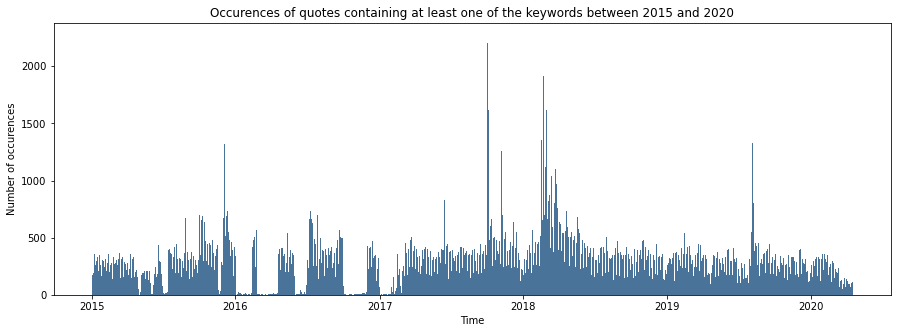

In [8]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'], bins=2000, color='#4a7399')

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. **But it has a major flaw**: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) for each day that contain at least one of the keywords.

In [9]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]

# Remove hour from the date
df['date'] = df['date'].dt.date

# Group by date and sum number of occurences
df = df.groupby(['date']).sum()
df = df.reset_index()

# Convert data column back to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=3)

,date,numOccurrences
0,2015-01-01,261
1,2015-01-02,555
2,2015-01-03,332


We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

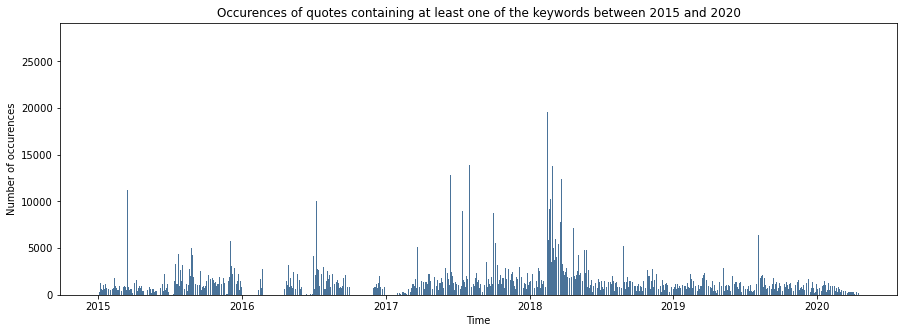

In [10]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.bar(df['date'],df['numOccurrences'],color='#4a7399')
plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

We have cleared a possible source of error out of the way. We will be using this new dataframe in the rest of the analysis. If we happen to need more information about the quotes that were said on a specific date, we can always switch back to looking for quotes on that specific date in the original dataframe (from the "cropped" Quotebank).

Since we will need this data later on, we save it to a new dataframe (data1). This way we can overwrite "df" without worrying.

In [11]:
# We will use this data in comparitive plots in part 3
data1 = df[['date','numOccurrences']]

## 2 - Initial analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the **"Mother Jone's US Mass Shootings" dataset**. Indeed, this dataset will give us some basic information about most shootings, such as: date, location, number of fatalities, number of injured, age of shooter, weapon type/legality...

In [12]:
# Reading the csv file
df = pd.read_csv('./Data/MassShootings.csv')

# Replace "-" by NaN in "age of shooter" column
df['age_of_shooter'] = df['age_of_shooter'].replace('-', np.nan).astype(float)

# Two new columns: location splitted into town and state
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Convert date column to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2020. Need to use same time span:
df = df.drop(df[df['date'].dt.year < 2015].index)
df = df.drop(df[df['date'].dt.year > 2020].index)

df.dtypes

case                                        object
location                                    object
date                                datetime64[ns]
summary                                     object
fatalities                                   int64
injured                                      int64
total_victims                                int64
location.1                                  object
age_of_shooter                             float64
prior_signs_mental_health_issues            object
mental_health_details                       object
weapons_obtained_legally                    object
where_obtained                              object
weapon_type                                 object
weapon_details                              object
race                                        object
gender                                      object
sources                                     object
mental_health_sources                       object
sources_additional_age         

To give us a first glimpse at the data, we can plot the fatalities per shooting accross time, as well as the distribution of the number of fatalities per shooting.

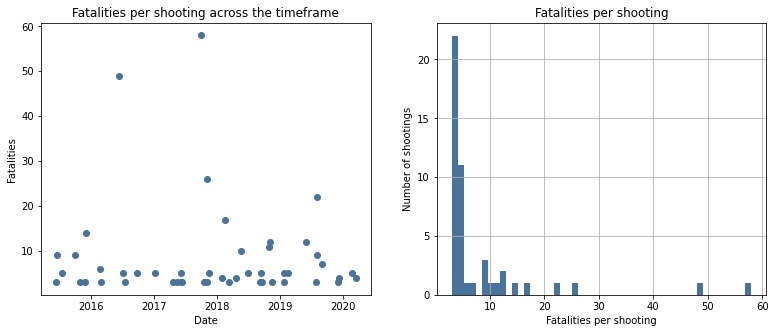

In [13]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Plot shootings in (time, number of fatalities) format
ax[0].scatter(df['date'], df['fatalities'], color='#4a7399')
ax[0].set_title('Fatalities per shooting across the timeframe')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Fatalities');

# Plot the distribution of the number of fatalities
ax[1] = df['fatalities'].hist(bins=50, color='#4a7399')
ax[1].set_xlabel('Fatalities per shooting')
ax[1].set_ylabel('Number of shootings')
ax[1].set_title('Fatalities per shooting');

There isn't much data, but we can say it seems to follow a **power law**: most of the shootings have a small number of fatalities (<10), but some large outliers are not unusual, some shootings having over 40 fatalities.

There are many paramters to explore, and one of them is **location** (as in the state) of the event:

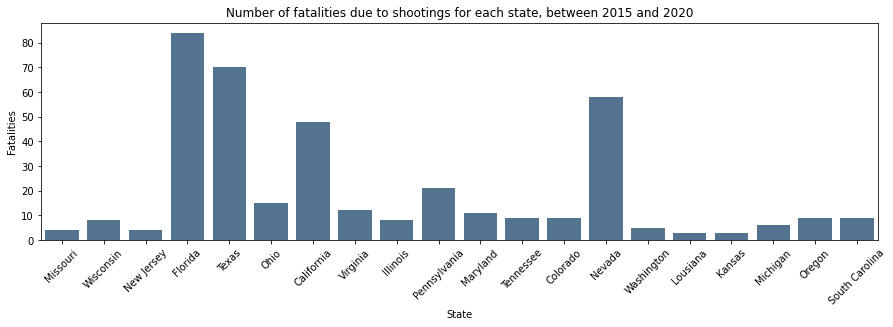

In [14]:
# Ploting the number of fatalities per state
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None, color='#4a7399')

ax.set_xlabel("State")
ax.set_ylabel("Fatalities")
ax.set_title("Number of fatalities due to shootings for each state, between 2015 and 2020")
plt.xticks(rotation=45)
plt.show()

With the above plot, we can clearly see that **states have been very unequally affected by mass shootings**. We will try to find some relevant correlations further on, such as average salary in the state, state political position (more of a 'blue state' or a 'red state'), etc.

We will now **explore some of the parameters in the dataset** (what kind of locations we have, weapon legality...). These are just examples, but they help highlight the fact that we have many parameters that can possibly affect the reaction each shooting will generate in the news.

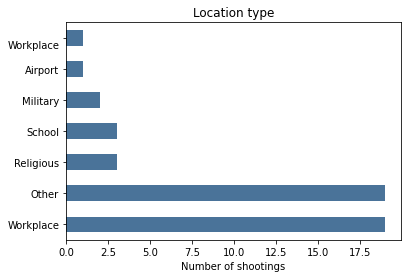

In [15]:
# Rename column location.1 to location1 (the dot is problematic)
df.rename(columns={"location.1": "location1"}, inplace=True)
                   
df.location1.value_counts().plot(kind='barh',color='#4a7399')
plt.title('Location type')
plt.xlabel('Number of shootings')
plt.show()

In [16]:
# Check if the used weapons were obtained legally or not:
df.weapons_obtained_legally.value_counts().head()

Yes        25
TBD         7
-           6
No          4
Unknown     3
Name: weapons_obtained_legally, dtype: int64

Most weapons were obtained legally.

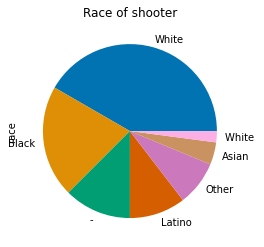

In [17]:
# Have a look of the race of the shooters
df.race.value_counts().plot(kind='pie',colors=sns.color_palette('colorblind'))
plt.title('Race of shooter')
plt.show()

Finally, we will use this dataframe in comparitive plots in part 3.
Therefore we save it to a new dataframe (in case we want to overwrite "df" further on):

In [18]:
data2 = df

## 3 - Linking the two datasets

### 3.1 - Plotting both datasets in the same timeline

We will start by plotting a single timeline graph with the number of fatalities due to shootings over time, as well as the occurence of gun-related words in the media.

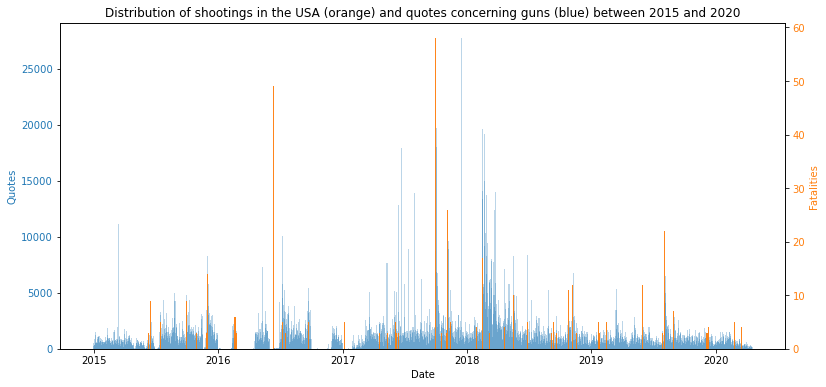

In [19]:
fig, ax1 = plt.subplots(figsize=(13,6))

# Plotting the quotes over time (blue)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (orange) and quotes concerning guns (blue) between 2015 and 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1['date'], data1['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (orange)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)
ax2.bar(data2['date'], data2['fatalities'], color=color, alpha=0.95, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

With the above print, we see that this peak is maximal exactly two days after the shooting.

We can see several interesting events in this first plot. For example, the largest peak in fatalities happens around october 2017. It is followed by the second largest peak in quotes talking about guns:

In [20]:
# Print the largest shooting (most fatalities)
data2 = data2.sort_values(by='fatalities',ascending=False)
data2 = data2.reset_index(drop=True)
print("The largest shooting was:")
print(data2.iloc[0])

# Quotes following the shooting (two days after)
data1 = data1.sort_values(by='numOccurrences',ascending=False)
print("\nThe corresponding peak in quotes discussing guns was:")
print(data1.iloc[1])

The largest shooting was:
case                                                         Las Vegas Strip massacre
location                                                            Las Vegas, Nevada
date                                                              2017-10-01 00:00:00
summary                             Stephen Craig Paddock, 64, fired a barrage of ...
fatalities                                                                         58
injured                                                                           546
total_victims                                                                     604
location1                                                                       Other
age_of_shooter                                                                   64.0
prior_signs_mental_health_issues                                                  TBD
mental_health_details               Perpetrator's history unclear. In 1969 Paddock...
weapons_obtained_legally    

### 3.2 - Correlation between mass shootings and number of quotes

Before going into any further analysis, we need to show that there is an association between the occurences of mass shootings (in orange) and the number of quotes in our subset (in blue). In order to do this, we will **test the correlation** between the number of quotes in the subset and the number of days since the last shooting.

In [21]:
# Create a new column with the day of the last shooting
data1['DateLastShooting'] = np.nan

for index, row in data1.iterrows():
    row_date = row['date']
    past_shootings = data2[data2['date'] < row_date]
    last_shooting = np.max(past_shootings['date'])
    data1.at[index, 'DateLastShooting'] = last_shooting

# Convert column to date-time format
data1['DateLastShooting'] = pd.to_datetime(data1['DateLastShooting'])

# Create another column with the number of days since the last shooting 
data1['DaysSinceLastShooting'] = (data1['date'] - data1['DateLastShooting']).dt.days
data1.sample()

,date,numOccurrences,DateLastShooting,DaysSinceLastShooting
1159,2018-03-11,6192,2018-03-09,2.0


In [22]:
# Drop rows containing missing values
data1_filtered = data1.dropna()

# Pearson correlation
from scipy.stats import stats
stats.pearsonr(data1_filtered['DaysSinceLastShooting'], data1_filtered['numOccurrences'])

(-0.16177454587465978, 7.993721727151127e-12)

We observe a **highly significant** (p-value << 0.05) **negative correlation** between the number of quotes on a given day and the days since the last shooting. This was the expected result: the more days since the last shooting, the rarer the quotes talking about guns and firearms.

### 3.3 - Influence of the number of fatalities on the count of quotes

We can see that the largest peak in quotes concerning guns takes place just after a shooting in early 2018:

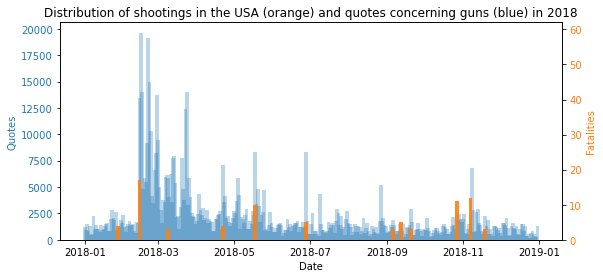

In [23]:
# We want to zoom in by looking only at 2018
data1_2018 = data1[(data1['date'].dt.year==2018)]
data2_2018 = data2[(data2['date'].dt.year==2018)]

fig, ax1 = plt.subplots(figsize=(9,4))

# Plotting the quotes over time (blue barplot)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (orange) and quotes concerning guns (blue) in 2018')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1_2018['date'], data1_2018['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (orange barplot)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)
ax2.bar(data2_2018['date'], data2_2018['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,62)

plt.show()

It seams that this particular event has made much more noise then the others and over a larger period of time. The fact that it was **certainly not the shooting with the most fatalities** ("only" 17, compared to 58 for the max) shows that the number of fatalities is clearly not the only parameter that influences the media coverage of the event as well as the amplitude of the discussion on gun control afterwards.

**This makes us want to investigate further: what are the other factors that can explain these differences?** Some ideas: 
- Location of the shooting (what state, but also what type of place: e.g. at a school, workplace...)
- Wheather of not the weapon was bought legally
- Age, gender and ethnicity of the shooter and/or the victims
- The type of weapon that was used
- etc.

### 3.4 - Computing the reaction score
In order to analyse the media's response to each shooting, we can start by selecting only the quotes from the following N days (for the moment we chose N=10 days). We did this for the top 3 most lethal shootings and plotted the results below. These again emphasize the idea that there is much more than just the number of fatalities (the second most lethal shooting creates a minimal response compared to the others).

In [24]:
# We want to zoom in for the 10 days after each shooting
from datetime import timedelta

# Create empty columns to fill for some key numbers regarding the shootings
data2['numQuotes_after_10'] = 0
data2['numQuotes_before_10'] = 0
data2['relative_increase'] = 0
#data2['slope'] = 0

for i in range(0,len(data2)):
    
    # Get the date of the (i+1)th most lethal shooting
    shooting_date = data2.sort_values(by='fatalities',ascending=False)['date'].iloc[i]

    # Select only the quotes in the 10 days before the selected shooting
    shooting_before =  data1[((data1['date'] <= shooting_date))]
    shooting_before =  shooting_before[(shooting_before['date'] > shooting_date - timedelta(days=10))]
    
    # For each shooting (each row in data2), add column with the number of quotes in the previous 10 days
    data2['numQuotes_before_10'].iloc[i] = shooting_before['numOccurrences'].sum()
    
    # Select only the quotes in the 10 days following the selected shooting
    shooting_after =  data1[((data1['date'] >= shooting_date))]
    shooting_after =  shooting_after[(shooting_after['date'] < shooting_date + timedelta(days=10))]
    
    # For each shooting (each row in data2), add column with the number of quotes in the next 10 days
    data2['numQuotes_after_10'].iloc[i] = shooting_after['numOccurrences'].sum()
    
    ## Get the slope of decrease in quotes after each shooting, gives a sense of how quick news faded
    #import datetime as dt
    #from sklearn import linear_model
    #shooting_after['date'] = pd.to_datetime(shooting_after['date']).map(dt.datetime.toordinal)
    #slope, intr, r, p_v, std = stats.linregress(shooting_after['date'], shooting_after['numOccurrences'])
    #data2['slope'].iloc[i] = slope
    
# For each shooting (each row in data2), add column with the number of quotes in the previous 10 days
data2['relative_increase'] = (data2.numQuotes_after_10 - data2.numQuotes_before_10)/data2.numQuotes_before_10
    
data2.head(n=2)

,case,location,date,summary,fatalities,injured,total_victims,location1,age_of_shooter,prior_signs_mental_health_issues,...,sources_additional_age,latitude,longitude,type,year,town,state,numQuotes_after_10,numQuotes_before_10,relative_increase
0,Las Vegas Strip massacre,"Las Vegas, Nevada",2017-10-01,"Stephen Craig Paddock, 64, fired a barrage of ...",58,546,604,Other,64.0,TBD,...,https://www.lvmpd.com/en-us/Documents/1_Octobe...,36.095739,-115.171544,Mass,2017,Las Vegas,Nevada,79309,20964,2.783104
1,Orlando nightclub massacre,"Orlando, Florida",2016-06-12,"Omar Mateen, 29, attacked the Pulse nighclub i...",49,53,102,Other,29.0,Unclear,...,http://www.motherjones.com/politics/2016/06/as...,28.519718,-81.376777,Mass,2016,Orlando,Florida,365,74,3.932432


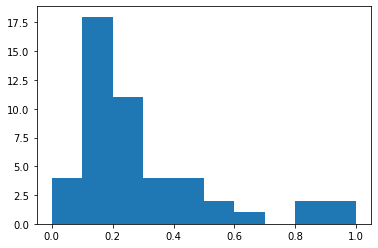

In [25]:
# Bring the relative_increase between 0 and 1
mini, maxi = data2.relative_increase.min(), data2.relative_increase.max()
data2.relative_increase = (data2.relative_increase - mini) /(maxi - mini)
plt.hist(data2.relative_increase, bins=10)
plt.show()

## Standardize the slope
#mean, std = data2.slope.mean(), data2.slope.std()
#mini, maxi = data2.slope.min(), data2.slope.max()
##data2.slope = (data2.slope - mean) / std
##plt.hist(data2.slope, bins=50)
## Normalize
#data2.slope = (data2.slope - mini) /(maxi - mini)

In [26]:
# Compute the reaction score for each shooting
data2['reaction_score'] = data2.relative_increase
data2.head(n=2)

,case,location,date,summary,fatalities,injured,total_victims,location1,age_of_shooter,prior_signs_mental_health_issues,...,latitude,longitude,type,year,town,state,numQuotes_after_10,numQuotes_before_10,relative_increase,reaction_score
0,Las Vegas Strip massacre,"Las Vegas, Nevada",2017-10-01,"Stephen Craig Paddock, 64, fired a barrage of ...",58,546,604,Other,64.0,TBD,...,36.095739,-115.171544,Mass,2017,Las Vegas,Nevada,79309,20964,0.688782,0.688782
1,Orlando nightclub massacre,"Orlando, Florida",2016-06-12,"Omar Mateen, 29, attacked the Pulse nighclub i...",49,53,102,Other,29.0,Unclear,...,28.519718,-81.376777,Mass,2016,Orlando,Florida,365,74,0.898197,0.898197


### 3.5 - Feature's influence on reaction score

We will start by plotting the average reaction scores for different types of features: location type, weapon type, weapon legality, gender of shooter, etc.

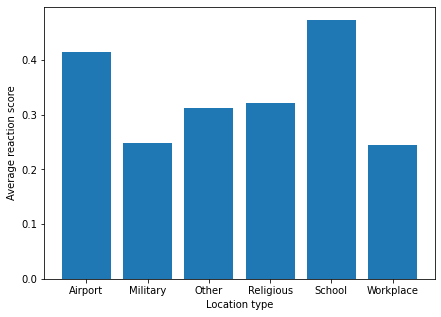

In [28]:
# Some of the locations were written as '\nWorkplace', we replace with 'Workplace'
data2.location1.replace('\nWorkplace', 'Workplace', inplace=True)

# Group all rows per location, and average the values of columns doing so
data_by = data2.groupby(['location1']).mean()
data_by = data_by.reset_index()

# Plot the reaction score average for each location type
fig = plt.subplots(figsize=(7,5))

# Plot the average reaction score for each location type
plt.bar(data_by.location1, data_by.reaction_score)
plt.xlabel('Location type')
plt.ylabel('Average reaction score')
plt.show()

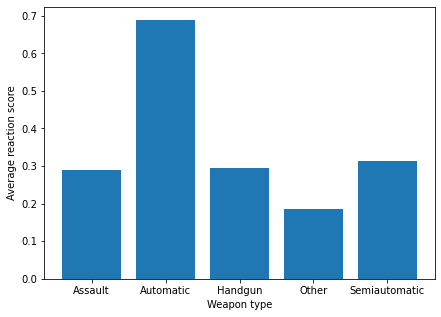

In [29]:
data2.weapon_type.replace('23 firearms, mostly rifles; including scopes, and two modified for "fully automatic" firing; two were mounted on tripods', 'Automatic', inplace=True)
data2.weapon_type.replace('Semiautomatic rifle, semiautomatic handgun', 'Semiautomatic', inplace=True)
data2.weapon_type.replace('semiautomatic rifle', 'Semiautomatic', inplace=True)
data2.weapon_type.replace(["Two assault rifles and two semi-automatic pistols were used in the attack. Police found a remote controlled explosive device at the scene of the crime. At the home were 12 pipe bombs, 2,500 rounds for the AR-15 variants, 2,000 rounds for the pistols, and several hundred for a .22 calibre rifle. In the suspects' car were an additional 1,400 rounds for the rifles and 200 for the handguns.",'2 assault rifles; semiautomatic handgun\n'], 'Assault', inplace=True)
data2.weapon_type.replace("semiautomatic handgun", 'Semiautomatic', inplace=True)
data2.weapon_type.replace("semiautomatic handgun", 'Semiautomatic', inplace=True)
data2.weapon_type.replace("semiautomatic rifle; semiautomatic handguns", 'Semiautomatic', inplace=True)
data2.weapon_type.replace(["Semiautomatic handgun', 'semiautomatic handgun\n", 
                           'semiautomatic rifle and semiautomatic handgun',
                          'Semiautomatic rifle, semiautomatic handguns',
                          'Semiautomatic handgun','semiautomatic handgun\n',
                          'semiautomatic rifles','Two semiautomatic rifles; one semiautomatic handgun',
                          'semiautomatic rifle; shotgun'], 'Semiautomatic', inplace=True)
data2.weapon_type.replace(['2 handguns','handgun','Two handguns and a rifle','handgun, shotgun',
                           'two handguns','Two handguns\n'], 'Handgun', inplace=True)
data2.weapon_type.replace(['shotgun; .38 revolver', 
                           'Five pistols, one rifle, five magazines of ammunition', 'Rifle',
                           'shotgun', '-', 'Long gun', 'shotguns'], 'Other', inplace=True)


# Group all rows by weapon type, and average the values of columns doing so
data_by = data2.groupby(['weapon_type']).mean()
data_by = data_by.reset_index()

# Plot the reaction score average for each location type
fig = plt.subplots(figsize=(7,5))

# Plot the average reaction score for each weapon type
plt.bar(data_by.weapon_type, data_by.reaction_score)
plt.xlabel('Weapon type')
plt.ylabel('Average reaction score')
plt.show()

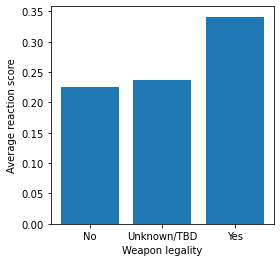

In [30]:
# Get only 'Yes', 'No' and 'Unknown/TBD' answers to legality of weapons
data2.weapons_obtained_legally.replace('\nYes', 'Yes', inplace=True)
data2.weapons_obtained_legally.replace('-', 'Unknown', inplace=True)
data2.weapons_obtained_legally.replace('TBD', 'Unknown', inplace=True)
data2.weapons_obtained_legally.replace('Yes ("some of the weapons were purchased legally and some of them may not have been")', 'Yes', inplace=True)
data2.weapons_obtained_legally.replace('Kelley passed federal criminal background checks; the US Air Force failed to provide information on his criminal history to the FBI', 'Unknown', inplace=True)
data2.weapons_obtained_legally.replace('Unknown', 'Unknown/TBD', inplace=True)

# Group all rows by weapon legality, and average the values of columns doing so
data_by = data2.groupby(['weapons_obtained_legally']).mean()
data_by = data_by.reset_index()

# Plot the reaction score average for each location type
fig = plt.subplots(figsize=(4,4))

# Plot the average reaction score for each weapon legality type
plt.bar(data_by.weapons_obtained_legally, data_by.reaction_score)
plt.xlabel('Weapon legality')
plt.ylabel('Average reaction score')
plt.show()

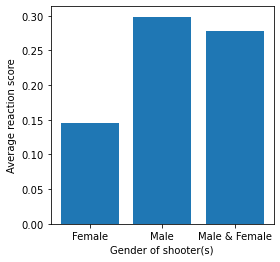

In [31]:
data2.gender.replace('M', 'Male', inplace=True)
data2.gender.replace('F', 'Female', inplace=True)

# Group all rows by gender, and average the values of columns doing so
data_by = data2.groupby(['gender']).mean()
data_by = data_by.reset_index()

# Plot the reaction score average for each location type
fig = plt.subplots(figsize=(4,4))

# Plot the average reaction score for each weapon legality type
plt.bar(data_by.gender, data_by.reaction_score)
plt.xlabel('Gender of shooter(s)')
plt.ylabel('Average reaction score')
plt.show()

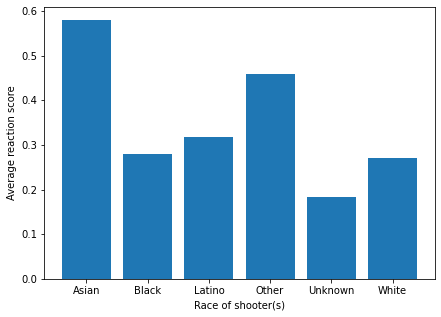

In [32]:
# Get only 'Yes', 'No' and 'Unknown/TBD' answers to legality of weapons
data2.race.replace('White ', 'White', inplace=True)
data2.race.replace('-', 'Unknown', inplace=True)

# Group all rows by gender, and average the values of columns doing so
data_by = data2.groupby(['race']).mean()
data_by = data_by.reset_index()

# Plot the reaction score average for each location type
fig = plt.subplots(figsize=(7,5))

# Plot the average reaction score for each weapon legality type
plt.bar(data_by.race, data_by.reaction_score)
plt.xlabel('Race of shooter(s)')
plt.ylabel('Average reaction score')
plt.show()

#### Regression analysis

In [33]:
regression_data = data2[['fatalities','location1','weapons_obtained_legally']]

In [34]:
# We need to make all the values numbers

# Make weapon legality a 0/1 value
for i in range(0,len(regression_data)):
    regression_data.weapons_obtained_legally.replace('Yes', 1, inplace=True)
    regression_data.weapons_obtained_legally.replace('No', 0, inplace=True)
    regression_data.weapons_obtained_legally.replace('Unknown/TBD', 0.5, inplace=True)

# Onehot encode the location types
locations = list(regression_data.location1.unique())

for location in locations:
    # New column {location}_onehot, with value 1 if location is {location}, 0 otherwise
    regression_data[location+'_onehot'] = np.where(regression_data['location1'] == location, 1, 0)
        
regression_data.drop('location1', axis=1, inplace=True)
regression_data.head(n=3)

,fatalities,weapons_obtained_legally,Other_onehot,Religious_onehot,Workplace_onehot,School_onehot,Airport_onehot,Military_onehot
0,58,1.0,1,0,0,0,0,0
1,49,1.0,1,0,0,0,0,0
2,26,0.5,0,1,0,0,0,0


In [35]:
# Get Z-scores for each column
for col in regression_data.columns:
    
    regression_data[col] = regression_data[col].astype('float')
    mean = regression_data[col].mean()
    std = regression_data[col].std()
    
    regression_data[col] = (regression_data[col] - mean) / std
    
regression_data.head()

,fatalities,weapons_obtained_legally,Other_onehot,Religious_onehot,Workplace_onehot,School_onehot,Airport_onehot,Military_onehot
0,4.606935,0.798839,1.222505,-0.255495,-0.836304,-0.255495,-0.144338,-0.206331
1,3.773520,0.798839,1.222505,-0.255495,-0.836304,-0.255495,-0.144338,-0.206331
2,1.643680,-0.734931,-0.800951,3.832427,-0.836304,-0.255495,-0.144338,-0.206331
3,1.273274,0.798839,-0.800951,-0.255495,1.170826,-0.255495,-0.144338,-0.206331
4,0.810265,0.798839,-0.800951,-0.255495,-0.836304,3.832427,-0.144338,-0.206331


In [36]:
regression_data['reaction_score'] = data2['reaction_score']

# Declares the model
mod = smf.ols(formula='reaction_score ~ fatalities + weapons_obtained_legally + School_onehot + Workplace_onehot', data=regression_data)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         reaction_score   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4.248
Date:                Sun, 12 Dec 2021   Prob (F-statistic):            0.00551
Time:                        16:08:00   Log-Likelihood:                 9.3010
No. Observations:                  48   AIC:                            -8.602
Df Residuals:                      43   BIC:                            0.7541
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## 4 - Visualizing the data on a map

Now we will move on to visualizing the data on a map.

In [37]:
# Create a STATIC map with Geopandas

# Start by importing states geometry
import geopandas
states = geopandas.read_file('Data/usa-states-census-2014.shp')
states = states.to_crs("EPSG:3395")

# Create a dataframe "geo_df" with a column "geometry" with points (longitude,latitude)
from shapely.geometry import Point, Polygon
geometry = [Point(xy) for xy in zip(df.longitude,df.latitude)]
geo_df = geopandas.GeoDataFrame(data2, crs={'init': 'epsg:4326'}, geometry=geometry)

/Users/thomasdefauw/miniconda3/envs/ada/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [38]:
# Now let's make it interactive using Folium maps
import folium
m = folium.Map(location=[38,-93], zoom_start=4, zoomControl= False, max_zoom=6, min_zoom=4)#, tiles='cartodbpositron')
               #min_lot=0,
               #max_lot=500,
               #min_lat=40,
               #max_lat=80,
               #max_bounds=True)

# Create a column called 'coord' that stores the coordinstes in a list form
geo_df['coord'] = geo_df[['latitude', 'longitude']].values.tolist()

# Create a new list with the popup texts
popup_text=[0]*len(geo_df)
for i in range(len(geo_df)):
    popup_text[i] = ("<h4><b>" + str(geo_df.case.iloc[i]) + "</h4></b>"
    + "<b>Reaction score: </b>"+ str(geo_df.reaction_score.iloc[i].round(2)) 
    + "<br>--------------------------------"
    + "<br><b>Fatalities: </b>" + str(geo_df.fatalities.iloc[i]) 
    + "<br><b>Location type: </b>" + str(geo_df.location1.iloc[i])
    + "<br><b>Weapon type: </b>" + str(geo_df.weapon_type.iloc[i])
    + "<br><b>Legal weapon: </b>" + str(geo_df.weapons_obtained_legally.iloc[i])
    + "<br><b>Gender of shooter: </b>" + str(geo_df.gender.iloc[i])
    + "<br><b>Race of shooter: </b>" + str(geo_df.race.iloc[i]))

# Plot all points (i.e. all shootings), marker size proportional to reaction score
for i in range(len(geo_df)):
    
    # Choose color for points on map depending on a condition
    if geo_df.location1.iloc[i] == 'School': color = 'red'
    else: color = 'blue'
    # Choose one color for all points
    color = 'red'
    
    folium.CircleMarker(location=geo_df.coord.iloc[i], 
                        radius=geo_df.reaction_score.values[i]*20, 
                        weight=1.5,
                        color = color,
                        fill_color=color,
                       tooltip = popup_text[i]).add_to(m)

m

In [39]:
m.save('map.html')

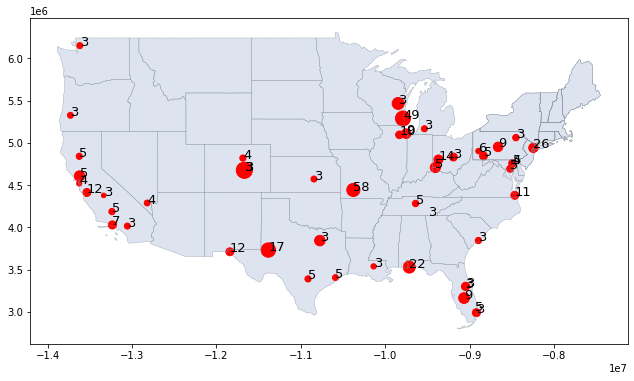

In [40]:
# Plot the map of the USA with the shootings
fig = plt.figure(1,figsize=(15,6))
ax = fig.add_subplot()

# Plot the states and their boundary
states.plot(ax=ax, color='#dde4f0', linewidth=.4)
states.boundary.plot(ax=ax, linewidth=.3, color='#818a99')

# Plot the shootings, size of marker proportional to reaction score
geo_df = geo_df.to_crs("EPSG:3395")
geo_df.plot(ax=ax, color='red', marker='.' , markersize=geo_df.reaction_score.values*1000)
#geo_df.plot(ax=ax, color='green', marker='.' , markersize=geo_df.fatalities.values*100)

# Show a lebel for the number of fatalities for each point
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.fatalities):
    ax.annotate(str(label), xy=(x,y), size=13)

## 4. Machine learning based analysis of word occurences

We have conducted some preliminary analysis with our subset of quotes, containing the words 'shoot, gun, firearm'. We have seen that these words are indeed correlated with events of mass shootings.

But before we go further, let's "reverse" the analysis, and check **what are the words that are associated the most with the occurences of mass shootings**. 

There are two goals in this : First, it would allow us to refine the first analysis, i.e. to find other relevant words. Secondly, it would provide us with a deeper insight on the discourse related to these tragic events. 

In [ ]:
# INSERT CODE MARKDOWN

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# We concatenate the csv files from all the years.
# We use the 'pivot' function to reshape from a melted format to a matrix
data2015 = pd.read_csv('Data/df_base_after_2015.csv')
data2016 = pd.read_csv('Data/df_base_after_2016.csv')
data2017 = pd.read_csv('Data/df_base_after_2017.csv')
data2018 = pd.read_csv('Data/df_base_after_2018.csv')
data2019 = pd.read_csv('Data/df_base_after_2019.csv')
data2020 = pd.read_csv('Data/df_base_after_2020.csv')

list_of_files = [data2015, data2016, data2017, data2018, data2019, data2020]
all_data = pd.concat(list_of_files, axis=0)

# we subset the "baseline" quotes as the outnumber greatly the 'after' quotes
baseline_quotes = list(set(all_data[all_data['group'] == 'baseline'].quote.tolist()))
after_quotes = list(set(all_data[all_data['group'] == 'after'].quote.tolist()))
subset_baseline_quotes = random.sample(baseline_quotes, len(baseline_quotes)//4)
kept_quotes = subset_baseline_quotes + after_quotes

all_data = all_data[all_data['quote'].isin(kept_quotes)]

all_data = all_data[all_data['word'].astype(str).str.isalpha()]
# we keep only words that occur more than 10 times 
all_data = all_data.groupby('word').filter(lambda x: len(x) > 10)

X = all_data.pivot(index='quote', columns='word', values='count')
# for computation efficency, we sample the data 

# X = quotes_data.pivot(index='quote', columns='word', values='count')
# X = pd.concat(list_of_files, axis=0)
# replace missing values by 0
X.fillna(0, inplace=True)
# counts to frequencies
X = X.div(X.sum(axis=1), axis=0)
print(X.head())
print(X.shape)

X.to_csv('Data/base_after_full.csv')

word                 aaron  abilities  ability  able  abortion  abroad  \
quote                                                                    
quote_2015_10001704    0.0        0.0      0.0   0.0       0.0     0.0   
quote_2015_10012249    0.0        0.0      0.0   0.0       0.0     0.0   
quote_2015_10013538    0.0        0.0      0.0   0.0       0.0     0.0   
quote_2015_10013842    0.0        0.0      0.0   0.0       0.0     0.0   
quote_2015_100206      0.0        0.0      0.0   0.0       0.0     0.0   

word                 absence  absolute  absolutely  abuse  ...  yield  york  \
quote                                                      ...                
quote_2015_10001704      0.0       0.0         0.0    0.0  ...    0.0   0.0   
quote_2015_10012249      0.0       0.0         0.0    0.0  ...    0.0   0.0   
quote_2015_10013538      0.0       0.0         0.0    0.0  ...    0.0   0.0   
quote_2015_10013842      0.0       0.0         0.0    0.0  ...    0.0   0.0   
quote_2

In [6]:
X = pd.read_csv('Data/base_after_full.csv', index_col='quote')
X.head()

,aaron,abilities,ability,able,abortion,abroad,absence,absolute,absolutely,abuse,...,yield,york,young,younger,youth,yung,zealand,zero,zone,zones
quote,,,,,,,,,,,,,,,,,,,,,
quote_2015_10001704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quote_2015_10012249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quote_2015_10013538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quote_2015_10013842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quote_2015_100206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# we extract the label information from the quotes_data df
y = [list(set(all_data.loc[all_data['quote'] == quote, 'group'].tolist()))[0] for quote in X.index]
le.fit(y)
y = le.transform(y)
print(y)

[1 1 1 ... 1 1 1]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

# init and fit the random forest
rf = RandomForestClassifier(n_estimators=400,
                            class_weight='balanced_subsample',
                            max_depth=10,
                            bootstrap=True,
                            random_state=0)
rf.fit(X_train, y_train)

# get the accuracy of the classifier
results = balanced_accuracy_score(y_test, rf.predict(X_test))
print(f'accuracy : {results}')

accuracy : 0.512317559316046


(4215,)
(15,)


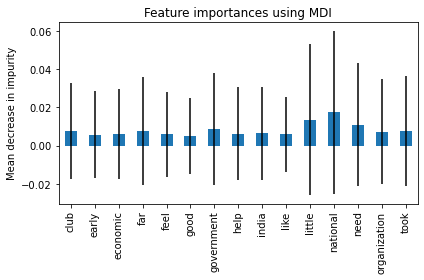

In [9]:
# based on: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Here we explore the feature importances
import matplotlib.pyplot as plt

# we gather the importance of features (words) as the MDI, and the std of MDI
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# we keep only the most informative (important) features
forest_importances = pd.Series(importances, index=feature_names)
print(forest_importances.shape)
thr = 0.005
most_std = std[forest_importances > thr]
most_important = forest_importances[forest_importances > thr]
print(most_important.shape)

# plotting
fig, ax = plt.subplots()
most_important.plot.bar(yerr=most_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("feat_importances_mdpi.pdf", format="pdf", bbox_inches="tight")


Even though our results are not very significative, it is still interesting to see what words pop out. We could try to regroup them into 3 categories : 

- Seriousness ('help', 'matter', 'important', 'unique')
- State ('national', 'gouvernment', 'campaign')
- Money ('ressources', 'money', 'wage')